In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Load data object and dictionary of angiogenesis gene modules

In [4]:
#load data object: prenatal skin data object, post qc with all celltypes

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
adata = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [6]:
#Gene sets from GO Biological Process 2021: see methods for corresponding GOnumbers

gene_sets_vasc = {'Positive regulation of angiogenesis' : ['/home/jovyan/projects/skin/fetal_skin/Gene sets/16042022/POSITIVE_REGULATION_OF_ANGIOGENESIS.txt'],
                'Positive regulation of sprouting angiogenesis' : ['/home/jovyan/projects/skin/fetal_skin/Gene sets/POSITIVE_REGULATION_OF_SPROUTING_ANGIOGENESIS.txt'],
                'Positive regulation of endothelial cell chemotaxis' : ['/home/jovyan/projects/skin/fetal_skin/Gene sets/POSITIVE_REGULATION_OF_ENDOTHELIAL_CELL_CHEMOTAXIS.txt'],
                'Positive regulation of endothelial cell proliferation' : ['/home/jovyan/projects/skin/fetal_skin/Gene sets/16042022/positive regulation of endothelial cell proliferation.txt'],
                'Blood vessel morphogenesis' : ['/home/jovyan/projects/skin/fetal_skin/Gene sets/16042022/blood vessel morphogenesis.txt']
                }

# Compute gene module scores across whole data object

In [7]:
for i in gene_sets_vasc.keys():
    gene_list_loc = ''.join(str(e) for e in gene_sets_vasc[i])
    gene_list_name = i
    gene_list = open(gene_list_loc, 'r')
    gene_list = gene_list.read().splitlines()
    gene_list = list(adata.var.index[adata.var.index.isin(gene_list)])
    print(len(gene_list))
    sc.tl.score_genes(adata, gene_list, ctrl_size=100, gene_pool=None, n_bins=25, score_name=(gene_list_name), random_state=0, copy=False)

115
computing score 'Positive regulation of angiogenesis'
    finished: added
    'Positive regulation of angiogenesis', score of gene set (adata.obs).
    1793 total control genes are used. (0:00:07)
15
computing score 'Positive regulation of sprouting angiogenesis'
    finished: added
    'Positive regulation of sprouting angiogenesis', score of gene set (adata.obs).
    598 total control genes are used. (0:00:07)
15
computing score 'Positive regulation of endothelial cell chemotaxis'
    finished: added
    'Positive regulation of endothelial cell chemotaxis', score of gene set (adata.obs).
    899 total control genes are used. (0:00:06)
75
computing score 'Positive regulation of endothelial cell proliferation'
    finished: added
    'Positive regulation of endothelial cell proliferation', score of gene set (adata.obs).
    1892 total control genes are used. (0:00:07)
56
computing score 'Blood vessel morphogenesis'
    finished: added
    'Blood vessel morphogenesis', score of gene

# Plot angiogenesis gene module scores

In [8]:
print(list(adata.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

In [10]:
# create a data object with macrophages only
mac = ['LYVE1++ macrophage', 'TREM2+ macrophage', 'Iron-recycling macrophage', 'MHCII+ macrophage']
adata_mac = adata[adata.obs['joint_annotation_20220202'].isin(mac)]
adata_mac

View of AnnData object with n_obs × n_vars = 24392 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [11]:
scores_mac = adata_mac.obs[[s for s in list(gene_sets_vasc.keys())]]
scores_mac['group'] = adata_mac.obs['joint_annotation_20220202']
#scores_mac.groupby('group').median()
score_mean_mac = scores_mac.groupby('group').mean()

In [12]:
#Z_score the data
score_mean_mac= (score_mean_mac - score_mean_mac.mean())/score_mean_mac.std()

In [13]:
#compute min, max and mid values
max_val_mac = (max((np.array(score_mean_mac)).max(0)))
min_val_mac = (min((np.array(score_mean_mac)).min(0)))
mid_val_mac = (max((np.array(score_mean_mac)).max(0))) - ((max((np.array(score_mean_mac)).max(0))) - (min((np.array(score_mean_mac)).min(0))))/2

In [14]:
score_mean_mac

,Positive regulation of angiogenesis,Positive regulation of sprouting angiogenesis,Positive regulation of endothelial cell chemotaxis,Positive regulation of endothelial cell proliferation,Blood vessel morphogenesis
group,,,,,
Iron-recycling macrophage,0.593335,-0.451880,0.643629,0.019650,0.184088
LYVE1++ macrophage,-0.495361,0.632834,0.963049,1.349097,1.269402
MHCII+ macrophage,1.045949,1.000154,-1.232041,-1.032811,-0.340470
TREM2+ macrophage,-1.143923,-1.181108,-0.374637,-0.335936,-1.113019


In [16]:
sc.settings.set_figure_params(dpi=150, dpi_save=1000)
sn.set(font_scale=0.7)
pal3 = sn.diverging_palette(240, 10, n=7)

Text(0.5, 24.375000000000007, 'cell_type')

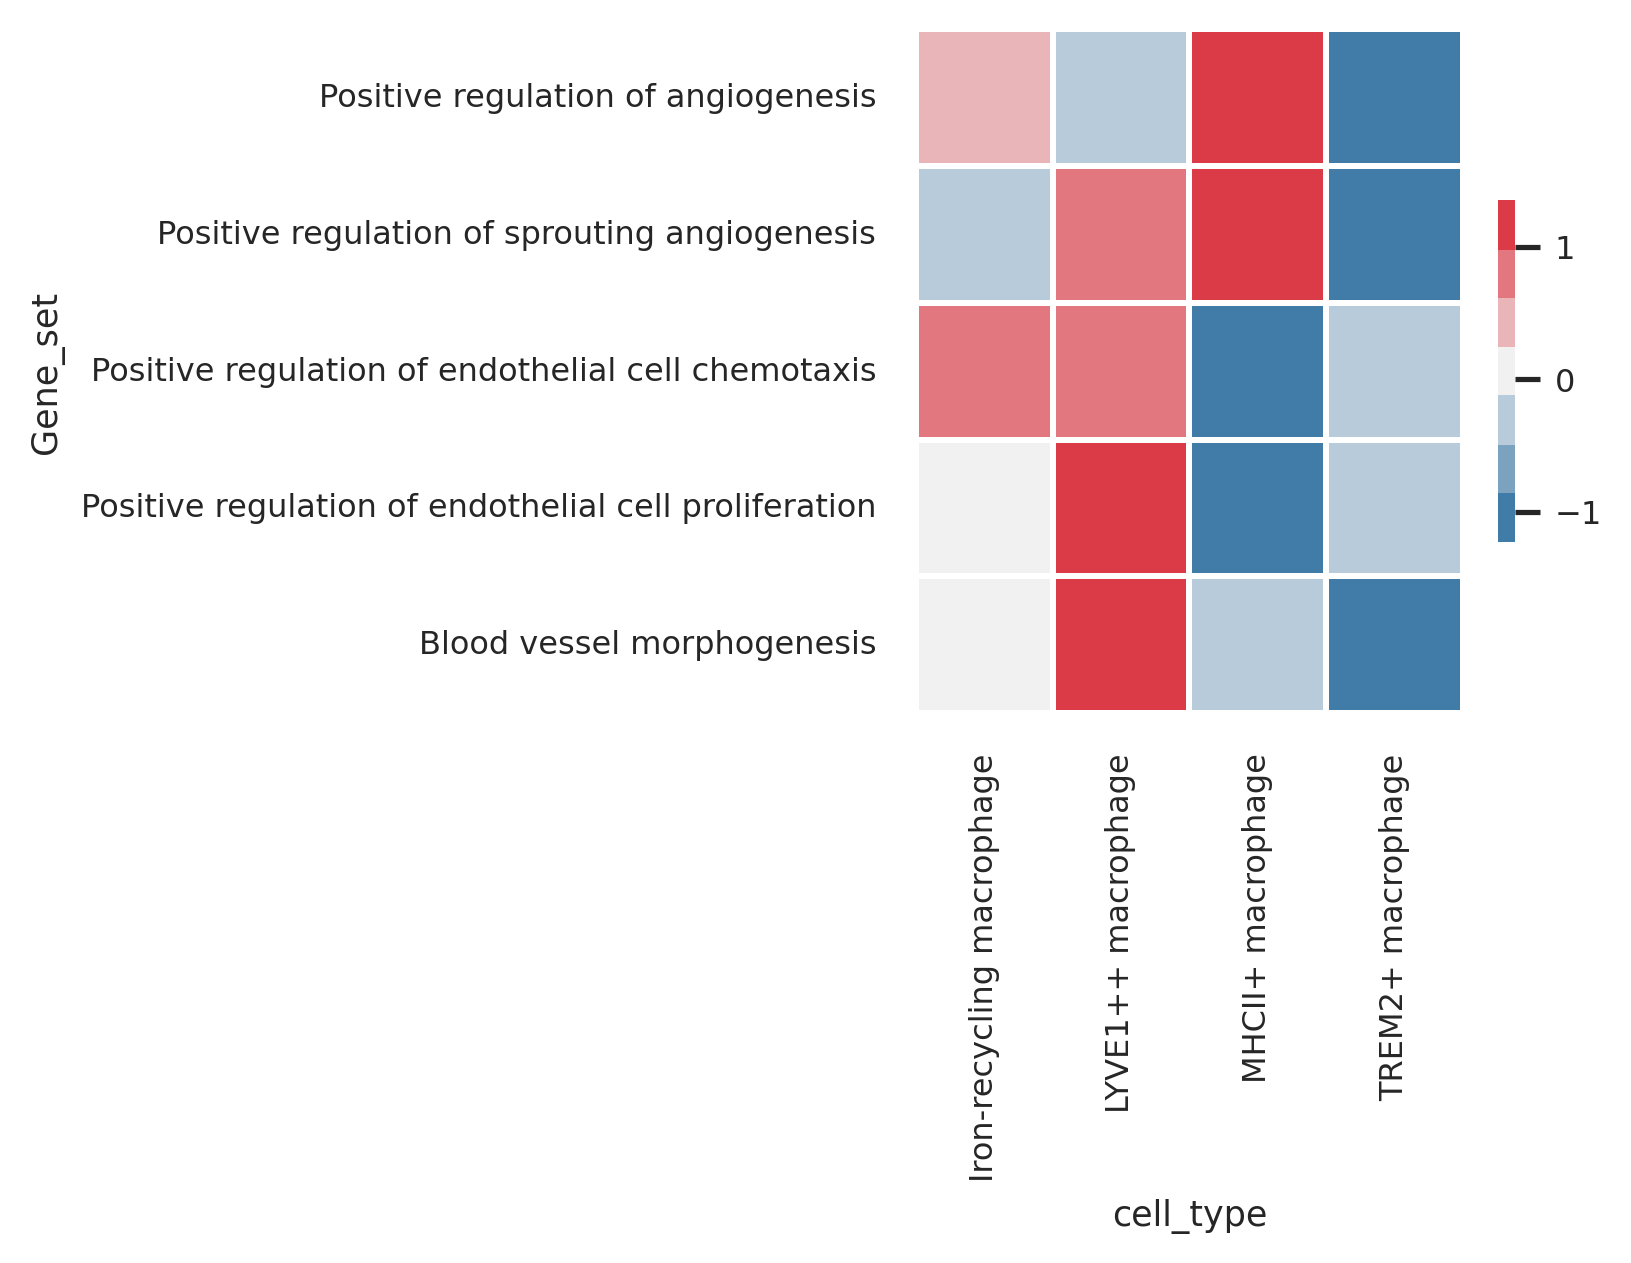

In [19]:
with matplotlib.rc_context({'figure.figsize' : (3,3)}):
    n = sn.heatmap(score_mean_mac.T, cmap=pal3, annot=False, vmin=min_val_mac, vmax=max_val_mac, linewidths=1, center=mid_val_mac, 
                square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Gene_set")
plt.xlabel("cell_type")
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/genesets_mac_positive.pdf',dpi=300, bbox_inches = "tight")